# Import Library

In [1]:
import os
import requests
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms


from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

import matplotlib.pyplot as plt

# Setting up directory, classes and their corr. labels

In [3]:
dataset_directory = "dataset"
classes = ["airplane", "apple", "banana", "bird", "bicycle", "clock"]
labels = [i for i in range(len(classes))]  

# Loading the np arrays

In [4]:
def load_npy_files(classes, dataset_directory="dataset"):
    data = []
    labels = []
    
    for i, cls in enumerate(classes):
        file_path = os.path.join(dataset_directory, f"{cls}.npy")
        if os.path.exists(file_path):
            class_data = np.load(file_path)
            data.append(class_data)
            labels.extend([i] * len(class_data))  # Assign integer labels based on class index
            print(f"Loaded data for class: {cls}")
        else:
            print(f"File not found for class: {cls}")

    data = np.concatenate(data, axis=0)
    labels = np.array(labels)
    return data, labels
classes = ["airplane", "apple", "banana", "bird", "bicycle", "clock"]

In [5]:

data, labels = load_npy_files(classes)

Loaded data for class: airplane
Loaded data for class: apple
Loaded data for class: banana
Loaded data for class: bird
Loaded data for class: bicycle
Loaded data for class: clock


# Setting some constants

In [6]:
in_channels = 1 #greyscale imgs
batch_size = 64
num_classes = len(classes)
learning_rate = 1e-3
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset class for pytorch 

In [7]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].astype(np.float32)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# Splitting the dataset into test, train and val

In [8]:
dataset = CustomDataset(data, labels)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Setting up the Data Loaders for pytorch

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last = True)

# Some images

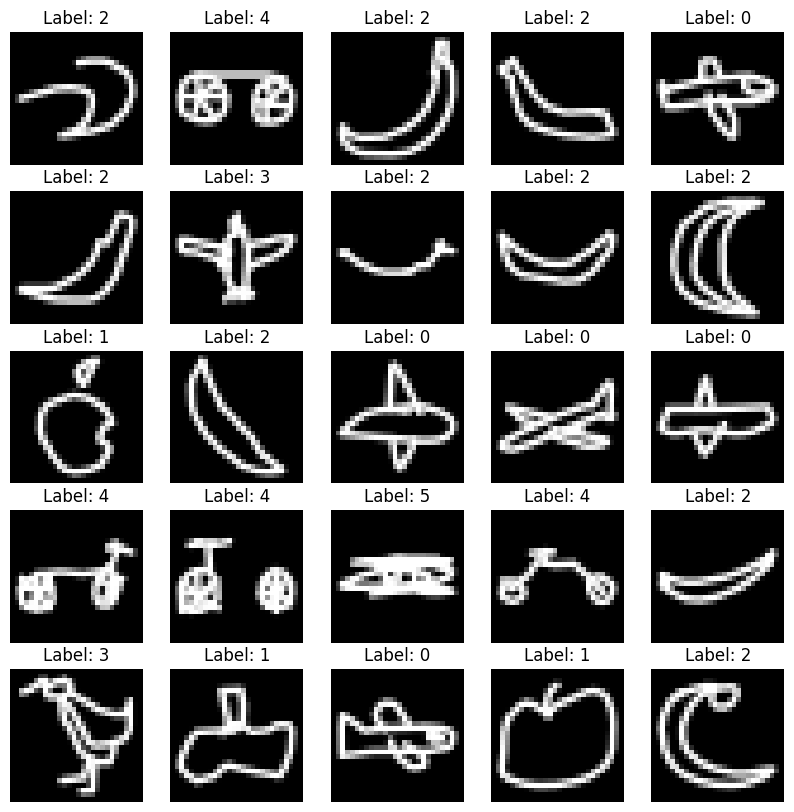

In [10]:
for images, labels in train_loader:
    plt.figure(figsize=(10, 10))
    for i in range(25):  
        image = images[i].reshape(28, 28)  # Reshape to 28x28 for display
        plt.subplot(5, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break


In [11]:
# # Assuming images[i] is a 1D array with shape (784,)
# image = images[i].reshape(28, 28)  # Reshape to 28x28 for display
# plt.subplot(5, 5, i + 1)
# plt.imshow(image, cmap='gray')
# plt.title(f"Label: {labels[i].item()}")
# plt.axis('off')


# CNN Arch.

In [12]:
class CNN(nn.Module):
    def __init__(self, in_channels = in_channels, num_classes = num_classes ):
        super(CNN, self).__init__()
        
#         [45] [58]  
#         [22] [12] 

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 14x14x5
            nn.Conv2d(5, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 7x7x8
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU() # 7x7x16
        )
        
        self.linear = nn.Sequential(
            nn.Linear(7*7*16, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(100, num_classes)
        )
                
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Ensure input shape is correct for Conv2d
        out = self.conv(x)
        out = out.view(out.shape[0], -1)
        out = self.linear(out)
        return out


# Setting up the model, criterion and optimizer

In [13]:
modelCNN = CNN(in_channels=in_channels, num_classes=num_classes).to(device=device) 
criterion = nn.CrossEntropyLoss()
optimizerCNN = optim.Adam(modelCNN.parameters(), lr=learning_rate)

# Fx. for accuracy of classified items

In [28]:
def get_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device).float()
            labels = labels.to(device)
            scores = model(data)

            _, predictions = scores.max(1)
            num_correct += (predictions == labels).sum()
            num_samples += predictions.size(0)
    print(f"Accuracy : {(num_correct / num_samples)*100:.2f}%") 
    return (num_correct / num_samples)*100

# Training Loop

In [16]:
# labels = labels.to(device).long()
# print(f"Labels dtype: {labels.dtype}")

In [17]:
# scores = modelCNN(data)
# print(f"Scores shape: {scores.shape}")  # Should be [batch_size, num_classes]


In [20]:
modelCNN.to(device)
data = data.to(device).float()

scores = modelCNN(data)
print(f"Scores dtype and device: {scores.dtype}, {scores.device}")

Scores dtype and device: torch.float32, cuda:0


In [21]:
scores = scores.to(torch.float32)
labels = labels.to(torch.long)
loss = criterion(scores, labels)

In [23]:
device = torch.device('cpu')
modelCNN.to(device)
data = data.to(device).float()
labels = labels.to(device, dtype=torch.long)

scores = modelCNN(data)
loss = criterion(scores, labels)
print("Loss computed successfully on CPU:", loss.item())

Loss computed successfully on CPU: 1.7565265893936157


In [30]:

trainLosses = []
valLosses = []

trainAcc = []
valAcc = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    modelCNN.train()
    train_loss = 0  

    for idx, (data, labels) in enumerate(train_loader):
        
        data = data.to(device).float()
        labels = labels.to(device, dtype=torch.long)

        scores = modelCNN(data)
        loss = criterion(scores, labels)
        optimizerCNN.zero_grad()
        loss.backward()
        
        #steepest slope
        optimizerCNN.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    trainLosses.append(avg_train_loss)
    
    train_acc = get_accuracy(train_loader, modelCNN)
    trainAcc.append(train_acc)
    
    modelCNN.eval()
    val_loss = 0
    with torch.no_grad():
        for idx, (data, labels) in enumerate(val_loader):
            data = data.to(device).float()
            labels = labels.to(device, dtype=torch.long)
            scores = modelCNN(data)
            loss = criterion(scores, labels)
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    valLosses.append(avg_val_loss)
    
    val_acc = get_accuracy(val_loader, modelCNN)
    valAcc.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Training Loss: {avg_train_loss:.4f} | "
          f"Validation Loss: {avg_val_loss:.4f}")

print("Training finished :)")

Accuracy : 96.21%
Accuracy : 95.99%
Epoch [1/5] | Training Loss: 0.1301 | Validation Loss: 0.1228
Accuracy : 96.50%
Accuracy : 96.18%
Epoch [2/5] | Training Loss: 0.1256 | Validation Loss: 0.1155
Accuracy : 96.45%
Accuracy : 96.17%
Epoch [3/5] | Training Loss: 0.1211 | Validation Loss: 0.1172
Accuracy : 96.56%
Accuracy : 96.25%
Epoch [4/5] | Training Loss: 0.1184 | Validation Loss: 0.1148
Accuracy : 96.51%
Accuracy : 96.21%
Epoch [5/5] | Training Loss: 0.1163 | Validation Loss: 0.1149
Training finished :)


# Accuracies

In [31]:
train_acc = get_accuracy(train_loader, modelCNN)

Accuracy : 96.51%


In [32]:
val_acc = get_accuracy(val_loader, modelCNN)

Accuracy : 96.21%


In [33]:
test_acc = get_accuracy(test_loader, modelCNN)

Accuracy : 96.24%


# Loss Graphs

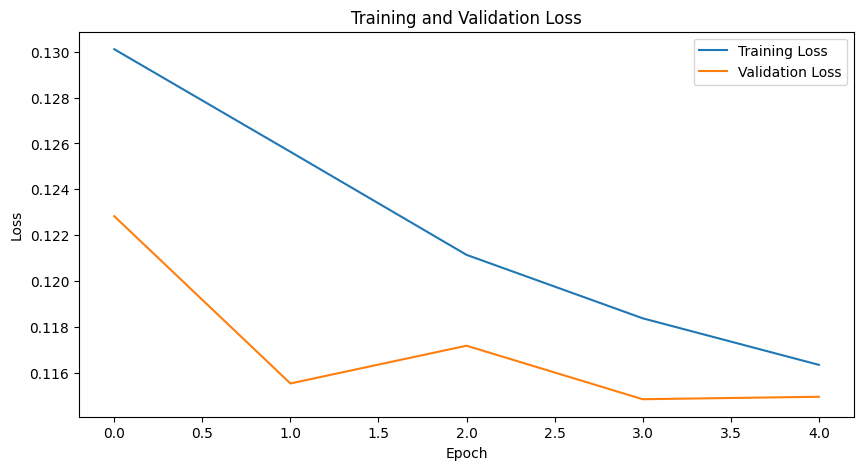

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(trainLosses, label='Training Loss')
plt.plot(valLosses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Accuracy Graphs

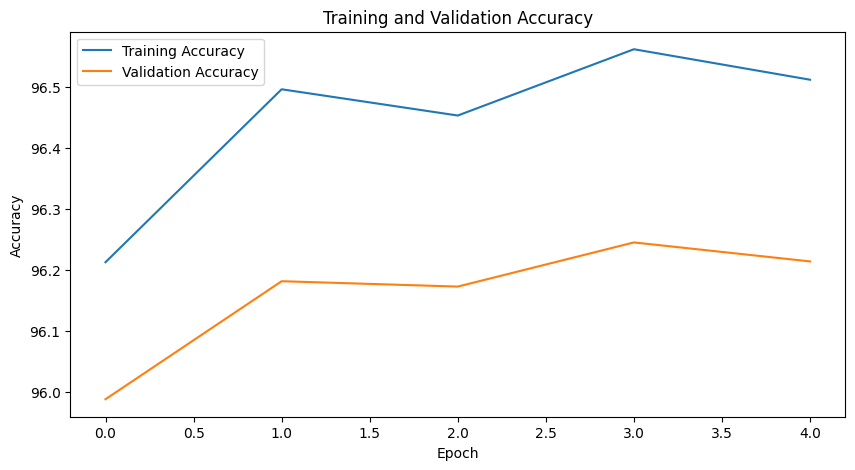

In [35]:
plt.figure(figsize=(10, 5))
plt.plot([j.cpu() for j in trainAcc], label='Training Accuracy')
plt.plot([j.cpu() for j in valAcc], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# Confusion Matrix for Test Data

In [36]:
def plot_confusion_matrix(loader, model):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device).float()
            labels = labels.to(device)
            scores = model(data)
            _, predictions = scores.max(1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Confusion Matrix for Test Data

In [37]:
def show_sample_predictions(loader, model, num_samples=25):
    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device).float()
            labels = labels.to(device)
            scores = model(data)
            _, predictions = scores.max(1)
            
            plt.figure(figsize=(16, 16))  # Adjust size as needed
            for i in range(num_samples):
                image = data[i].cpu().squeeze(0).numpy()
                plt.subplot(5, 5, i + 1)  # 5x5 grid for 25 images
                plt.imshow(image, cmap='gray')
                plt.title(f"True: {classes[labels[i].item()]}\nPred: {classes[predictions[i].item()]}")
                plt.axis('off')
            plt.show()
            break


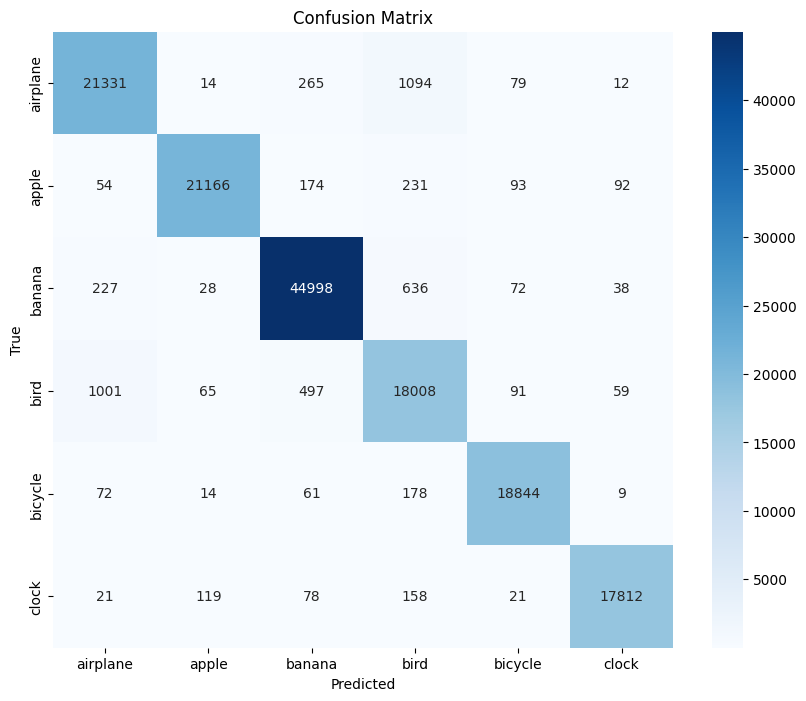

In [38]:
plot_confusion_matrix(test_loader, modelCNN)

# F1 scores

In [39]:
def get_f1_score(loader, model):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device).float()
            labels = labels.to(device)
            scores = model(data)
            _, predictions = scores.max(1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return f1_score(all_labels, all_preds, average='weighted')



In [40]:
train_f1 = get_f1_score(train_loader, modelCNN)
val_f1 = get_f1_score(val_loader, modelCNN)
test_f1 = get_f1_score(test_loader, modelCNN)

print(f"Training F1-Score: {train_f1:.2f}")
print(f"Validation F1-Score: {val_f1:.2f}")
print(f"Test F1-Score: {test_f1:.2f}")


Training F1-Score: 0.97
Validation F1-Score: 0.96
Test F1-Score: 0.96


# Some sample predictions on test data

In [42]:
def show_sample_predictions(loader, model, num_samples=25):
    model.eval()
    data_iter = iter(loader)
    data, labels = next(data_iter)
    
    data, labels = data.to(device), labels.to(device)
    with torch.no_grad():
        predictions = model(data).argmax(dim=1)
    
    plt.figure(figsize=(10, 10))
    for i in range(min(num_samples, data.size(0))):
        image = data[i].cpu().squeeze(0).numpy().reshape(28, 28)  # Reshape to 2D
        plt.subplot(5, 5, i + 1)  # 5x5 grid for 25 images
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {classes[labels[i].item()]}\nPred: {classes[predictions[i].item()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [44]:
torch.save(modelCNN.state_dict(), "doodle_model.pth")
print("Model saved to doodle_model.pth")

Model saved to doodle_model.pth


In [1]:
import tkinter as tk
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import torch
import torch.nn as nn  # Import the module where your model's class definition is

# Load your trained model
# Assuming your model class is defined as ModelCNN (replace with your actual model class name)
model = CNN()  # Replace with the actual class name if different
model.load_state_dict(torch.load("doodle_model.pth"))
model.eval()  # Set model to evaluation mode

class DoodleApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Doodle Canvas")
        
        # Create a canvas widget for drawing
        self.canvas = tk.Canvas(root, bg="white", width=280, height=280)
        self.canvas.pack()

        # Set up a PIL image to draw on
        self.image = Image.new("L", (280, 280), "white")  # L mode for grayscale
        self.draw = ImageDraw.Draw(self.image)

        # Bind mouse events for drawing
        self.canvas.bind("<B1-Motion>", self.paint)

        # Button to clear the canvas
        self.clear_button = tk.Button(root, text="Clear", command=self.clear)
        self.clear_button.pack(side=tk.LEFT)
        
        # Button to predict the doodle
        self.predict_button = tk.Button(root, text="Predict", command=self.predict_doodle)
        self.predict_button.pack(side=tk.RIGHT)

    def paint(self, event):
        x1, y1 = (event.x - 5), (event.y - 5)
        x2, y2 = (event.x + 5), (event.y + 5)
        self.canvas.create_oval(x1, y1, x2, y2, fill="black", width=5)
        self.draw.ellipse([x1, y1, x2, y2], fill="black")

    def clear(self):
        self.canvas.delete("all")
        self.draw.rectangle([0, 0, 280, 280], fill="white")

    def preprocess_image(self):
        # Resize to the model's expected input shape, e.g., 28x28
        img = self.image.resize((28, 28))  # Adjust size to model input
        img = ImageOps.invert(img)  # Invert if model expects white-on-black
        img = np.array(img).reshape(1, 1, 28, 28) / 255.0  # Normalize and reshape to (1, 1, 28, 28)
        img = torch.tensor(img, dtype=torch.float32)  # Convert to tensor
        return img

    def predict_doodle(self):
        img = self.preprocess_image()
        with torch.no_grad():  # Disable gradient calculation for inference
            prediction = model(img).argmax(dim=1).item()  # Get predicted class
        print(f"Predicted label: {prediction}")

# Run the app
root = tk.Tk()
app = DoodleApp(root)
root.mainloop()


NameError: name 'CNN' is not defined